In [1]:
import matplotlib
import matplotlib.pyplot as plt
import argparse
import random
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
from scipy.io import loadmat

### Load dataset

In [4]:
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=0, help='random seed (default: 0)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=300,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int,
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int,
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int,
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float,
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=1, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')
parser.add_argument('--random_search_it', type=int, default=20,
                    help='iterations of random search (default: 20)')

args = parser.parse_args()

In [5]:
args

Namespace(file='/home/irene/.local/share/jupyter/runtime/kernel-v3a4d928a04fb66ef1c8fdef0e3c6c803b3600849c.json', dataset='mnist', seed=0, cuda=1, gpuID=0, epochs=300, batch_size=64, batch_size_val=200, learning_rate=0.001, decay_epoch=-1, lr_decay=0.5, num_classes=10, gaussian_size=64, input_size=784, train_proportion=1.0, init_temp=1.0, decay_temp=1, hard_gumbel=0, min_temp=0.5, decay_temp_rate=0.013862944, w_gauss=1, w_categ=1, w_rec=1, rec_type='bce', verbose=0, random_search_it=20)

In [6]:
if args.dataset == "mnist":
  print("Loading mnist dataset...")
  # Download or load downloaded MNIST dataset
  train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
  test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

Loading mnist dataset...


In [7]:
image, label = train_dataset[0]
print("Image size:", image.size())
print("Label:", label)

Image size: torch.Size([1, 28, 28])
Label: 5


In [9]:
def show_image(image):
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

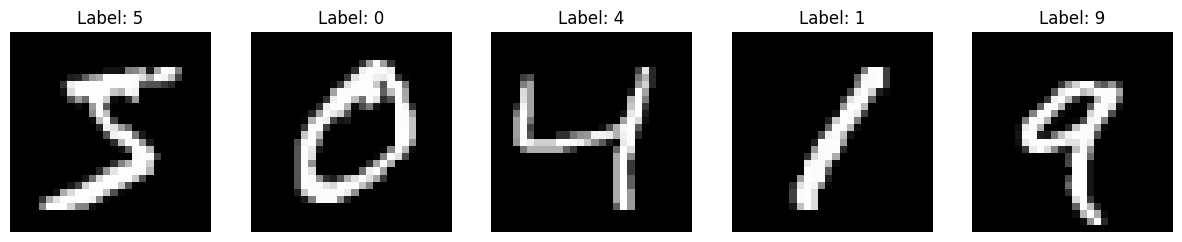

In [10]:
plt.figure(figsize=(15, 3))  # Set the figure size

# Display the first 5 images
for i in range(5):
    image, label = train_dataset[i]
    plt.subplot(1, 5, i + 1)  # Create subplots for each image
    plt.imshow(image.squeeze().numpy(), cmap='gray')  # Convert tensor to numpy array and display
    plt.title('Label: %d' % label)  # Set the title
    plt.axis('off')  # Turn off axis

plt.show()

In [11]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # Create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)

In [12]:
for batch in train_loader:
    img, lab = batch

In [13]:
img.shape, lab.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [14]:
## Calculate flatten size of each input data
args.input_size = np.prod(train_dataset[0][0].size())
print(args.input_size)

784


## Network

### reshape and flatten

In [15]:
# Flatten layer
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.size(0), -1)

# Reshape layer
class Reshape(nn.Module):
  def __init__(self, outer_shape):
    super(Reshape, self).__init__()
    self.outer_shape = outer_shape
  def forward(self, x):
    return x.view(x.size(0), *self.outer_shape)

### Gumbel Softmax

In [16]:
# Sample from the Gumbel-Softmax distribution and optionally discretize.
# The Gumbel-Softmax distribution is a continuous relaxation of the categorical distribution
class GumbelSoftmax(nn.Module):

  def __init__(self, f_dim, c_dim):
    super(GumbelSoftmax, self).__init__()
    self.logits = nn.Linear(f_dim, c_dim)
    self.f_dim = f_dim
    self.c_dim = c_dim
    """
    f_dim := feature dimension
    c_dim := number of categories
    logits := takes input of size f_dim and outputs c_dim dimensional logits
    """

  def sample_gumbel(self, shape, is_cuda=False, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
      U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

  def gumbel_softmax_sample(self, logits, temperature):
    y = logits + self.sample_gumbel(logits.size(), logits.is_cuda)
    return F.softmax(y / temperature, dim=-1)

  def gumbel_softmax(self, logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    #categorical_dim = 10
    y = self.gumbel_softmax_sample(logits, temperature)

    if not hard:
        return y

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard

  def forward(self, x, temperature=1.0, hard=False):
    logits = self.logits(x).view(-1, self.c_dim)
    prob = F.softmax(logits, dim=-1)
    y = self.gumbel_softmax(logits, temperature, hard)
    return logits, prob, y

In [17]:
# Define an instance of GumbelSoftmax module
f_dim = 10  # Feature dimension
c_dim = 3   # Number of categories
gumbel_softmax = GumbelSoftmax(f_dim, c_dim)

# Generate random input tensor
batch_size = 2
input_tensor = torch.randn(batch_size, f_dim)

# Test forward pass without hard sampling
logits, probabilities, sampled_values = gumbel_softmax(input_tensor)
print("Logits:\n", logits.detach().numpy()) # (batch_size, c_dim)
print("Probabilities:\n", probabilities.detach().numpy()) # Applying the softmax function to the logits, we obtain probabilities for each category
print("Sampled Values:\n", sampled_values.detach().numpy()) # Contains the sampled values obtained by applying Gumbel-Softmax sampling to the logits
print("")

# Test forward pass with hard sampling
logits_hard, probabilities_hard, sampled_values_hard = gumbel_softmax(input_tensor, hard=True)
print("Logits (Hard):\n", logits_hard.detach().numpy())
print("Probabilities (Hard):\n", probabilities_hard.detach().numpy())
print("Sampled Values (Hard):\n", sampled_values_hard.detach().numpy())

Logits:
 [[-0.40871793  0.6780799  -0.12190421]
 [ 0.48840606  0.7203516   0.39674193]]
Probabilities:
 [[0.1887882  0.5597127  0.25149915]
 [0.31511322 0.39737386 0.28751296]]
Sampled Values:
 [[0.39117974 0.21984187 0.38897836]
 [0.01411002 0.01306371 0.9728263 ]]

Logits (Hard):
 [[-0.40871793  0.6780799  -0.12190421]
 [ 0.48840606  0.7203516   0.39674193]]
Probabilities (Hard):
 [[0.1887882  0.5597127  0.25149915]
 [0.31511322 0.39737386 0.28751296]]
Sampled Values (Hard):
 [[0. 1. 0.]
 [0. 1. 0.]]


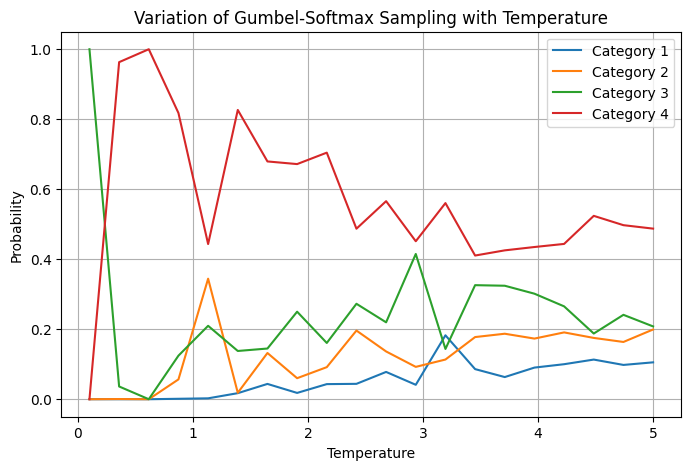

In [18]:
# NOTE: The temperature parameter controls the "softness" of the sampling process.
# Higher temperatures lead to softer distributions where the probabilities across categories are more evenly spread out,
# while lower temperatures result in harder distributions with sharper peaks

def sample_gumbel(shape, is_cuda=False, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
      U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size(), logits.is_cuda)
    return F.softmax(y / temperature, dim=-1)
# Define logits
logits = torch.tensor([-1.0, 1.0, 2.0, 5.0])

# Define temperature range
temperatures = torch.linspace(0.1, 5, 20)

# Perform Gumbel-Softmax sampling for each temperature
samples = [gumbel_softmax_sample(logits, temp) for temp in temperatures]

# Convert samples to numpy array for plotting
samples_np = torch.stack(samples).numpy()

# Plot the sampled values for each temperature
plt.figure(figsize=(8, 5))
for i in range(logits.size(0)):
    plt.plot(temperatures.numpy(), samples_np[:, i], label=f'Category {i+1}')

plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Variation of Gumbel-Softmax Sampling with Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Sample from a Gaussian distribution
class Gaussian(nn.Module):
  def __init__(self, in_dim, z_dim):
    super(Gaussian, self).__init__()
    self.mu = nn.Linear(in_dim, z_dim)
    self.var = nn.Linear(in_dim, z_dim)

  def reparameterize(self, mu, var):
    std = torch.sqrt(var + 1e-10)
    noise = torch.randn_like(std)
    z = mu + noise * std
    return z

  def forward(self, x):
    mu = self.mu(x)
    var = F.softplus(self.var(x))
    z = self.reparameterize(mu, var)
    return mu, var, z

In [20]:
# Example usage
# Define input tensor x
x = torch.randn(1, 10)

# Define the Gaussian module with input dimension 10 and latent space dimension 5
gaussian = Gaussian(10, 5)

# Forward pass through the Gaussian module
mu, var, z = gaussian(x)

# Print the mean, variance, and sampled latent variable
print("Mean:", mu.detach().numpy())
print("Variance:", var.detach().numpy())
print("Sampled latent variable z:", z.detach().numpy())

Mean: [[ 0.79807836  0.8314303   0.25616997  0.7815232  -0.99420846]]
Variance: [[0.53094184 0.36039448 0.97503376 1.0084803  0.7400134 ]]
Sampled latent variable z: [[2.239582   1.257196   0.33589345 0.29167324 0.02851951]]


In [21]:
import torch.nn.init as init

### Inference Network

In [22]:
# Inference Network
class InferenceNet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(InferenceNet, self).__init__()

    # q(y|x)
    self.inference_qyx = torch.nn.ModuleList([
        nn.Linear(x_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        GumbelSoftmax(512, y_dim)
    ])

    # q(z|y,x)
    self.inference_qzyx = torch.nn.ModuleList([
        nn.Linear(x_dim + y_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        Gaussian(512, z_dim)
    ])

  # q(y|x)
  def qyx(self, x, temperature, hard):
    num_layers = len(self.inference_qyx)
    for i, layer in enumerate(self.inference_qyx):
      if i == num_layers - 1:
        #last layer is gumbel softmax
        x = layer(x, temperature, hard)
      else:
        x = layer(x)
    return x

  # q(z|x,y)
  def qzxy(self, x, y):
    concat = torch.cat((x, y), dim=1)
    for layer in self.inference_qzyx:
      concat = layer(concat)
    return concat

  def forward(self, x, temperature=1.0, hard=0):
    #x = Flatten(x)

    # q(y|x)
    logits, prob, y = self.qyx(x, temperature, hard)

    # q(z|x,y)
    mu, var, z = self.qzxy(x, y)

    output = {'mean': mu, 'var': var, 'gaussian': z,
              'logits': logits, 'prob_cat': prob, 'categorical': y}
    return output

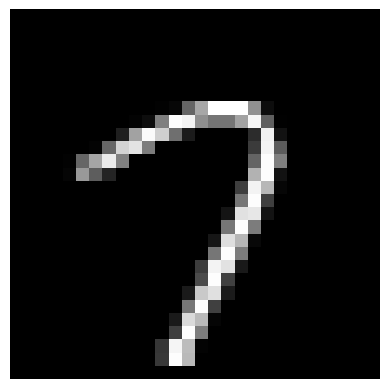

In [23]:
show_image(img[3])

In [ ]:
image = img[0].unsqueeze(0) # Batch = 1
print(image.shape)

flatten_img = image.view(image.size(0), -1)
print(flatten_img.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 784])


In [ ]:
# Example usage
# Assuming x_dim = 784, z_dim = 8, y_dim = 10
x_dim = 784
z_dim = 8
y_dim = 10

# Create an instance of InferenceNet
inference_net = InferenceNet(x_dim, z_dim, y_dim)

# Perform forward pass
output = inference_net(flatten_img)

# Print the outputprint("Output:")
for key, value in output.items():
    print(f"{key}: {value}")
print("")
print(output['categorical'].sum())

mean: tensor([[ 0.0429,  0.0269, -0.0333,  0.0139,  0.0355,  0.0431, -0.0437, -0.0598]],
       grad_fn=<AddmmBackward0>)
var: tensor([[0.6674, 0.6858, 0.6882, 0.6907, 0.7103, 0.7010, 0.7017, 0.7113]],
       grad_fn=<SoftplusBackward0>)
gaussian: tensor([[ 0.1393,  0.6309,  0.5502,  0.0596, -0.0799, -0.2003, -0.4913,  0.4430]],
       grad_fn=<AddBackward0>)
logits: tensor([[-0.0344,  0.0497, -0.0243, -0.0053, -0.0443, -0.0624,  0.0663, -0.0343,
          0.0204, -0.0280]], grad_fn=<ViewBackward0>)
prob_cat: tensor([[0.0975, 0.1060, 0.0985, 0.1004, 0.0965, 0.0948, 0.1078, 0.0975, 0.1030,
         0.0981]], grad_fn=<SoftmaxBackward0>)
categorical: tensor([[0.0875, 0.0236, 0.0230, 0.0393, 0.1012, 0.2071, 0.2402, 0.1907, 0.0427,
         0.0446]], grad_fn=<SoftmaxBackward0>)

tensor(1., grad_fn=<SumBackward0>)


### Generative Network

In [ ]:
# Example usage
# Assuming x_dim = 784, z_dim = 8, y_dim = 10
x_dim = 784
z_dim = 8
y_dim = 10

# Create an instance of GenerativeNet
generative_net = GenerativeNet(x_dim, z_dim, y_dim)

# Perform forward pass
output_gen = generative_net(output['gaussian'], output['categorical'])

# Print the output
for key, value in list(output_gen.items())[:-1]:
    print(f"{key}: {value}")

y_mean: tensor([[ 0.1394, -0.0713, -0.0173, -0.1156,  0.0091, -0.0403,  0.1787,  0.2153]],
       grad_fn=<AddmmBackward0>)
y_var: tensor([[0.6774, 0.5331, 0.8039, 0.7291, 0.7071, 0.7383, 0.7024, 0.6901]],
       grad_fn=<SoftplusBackward0>)


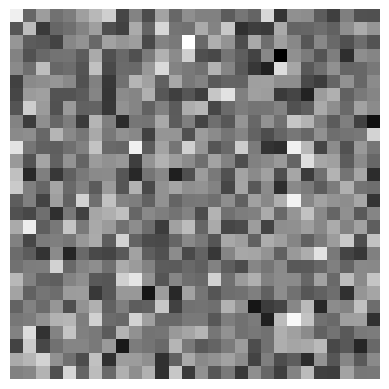

In [ ]:
show_image(output_gen['x_rec'].view(1,28,28).detach())

### GM VAE

In [ ]:
# GMVAE Network
class GMVAENet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(GMVAENet, self).__init__()

    self.inference = InferenceNet(x_dim, z_dim, y_dim)
    self.generative = GenerativeNet(x_dim, z_dim, y_dim)

    # weight initialization
    for m in self.modules():
      if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias.data is not None:
          init.constant_(m.bias, 0)

  def forward(self, x, temperature=1.0, hard=0):
    x = x.view(x.size(0), -1)
    out_inf = self.inference(x, temperature, hard)
    z, y = out_inf['gaussian'], out_inf['categorical']
    out_gen = self.generative(z, y)

    # merge output
    output = out_inf
    for key, value in out_gen.items():
      output[key] = value
    return output

In [ ]:
# Example usage
# Assuming x_dim = 784 (28x28), z_dim = 8, y_dim = 10
x_dim = 784
z_dim = 8
y_dim = 10

# Create an instance of GMVAENet
gmvae_net = GMVAENet(x_dim, z_dim, y_dim)

# Perform forward pass
output = gmvae_net(image)

# Print the output
for key, value in list(output.items())[:-1]:
    print(f"{key}: {value}")

mean: tensor([[-0.0345, -0.6229, -0.2525, -0.0194, -0.4370,  0.5409, -0.3377, -0.2891]],
       grad_fn=<AddmmBackward0>)
var: tensor([[0.4427, 0.5917, 0.9372, 0.5736, 0.9378, 0.4690, 0.7494, 0.8137]],
       grad_fn=<SoftplusBackward0>)
gaussian: tensor([[-0.4575, -0.0401,  0.3573, -0.3004, -0.3500,  0.8159, -0.0202, -1.7037]],
       grad_fn=<AddBackward0>)
logits: tensor([[ 0.3284, -0.2401, -0.4613,  0.0112,  0.1685,  0.4605,  0.2769,  0.1998,
          0.1266,  0.3118]], grad_fn=<ViewBackward0>)
prob_cat: tensor([[0.1194, 0.0677, 0.0542, 0.0870, 0.1018, 0.1363, 0.1134, 0.1050, 0.0976,
         0.1175]], grad_fn=<SoftmaxBackward0>)
categorical: tensor([[0.1220, 0.0158, 0.3028, 0.0769, 0.0427, 0.1596, 0.0772, 0.1133, 0.0376,
         0.0522]], grad_fn=<SoftmaxBackward0>)
y_mean: tensor([[-0.0881, -0.0102, -0.1182,  0.0603,  0.3362, -0.1943,  0.0622,  0.0760]],
       grad_fn=<AddmmBackward0>)
y_var: tensor([[0.8292, 0.6237, 0.7135, 0.6584, 0.7482, 0.5977, 0.6787, 0.7785]],
       gra

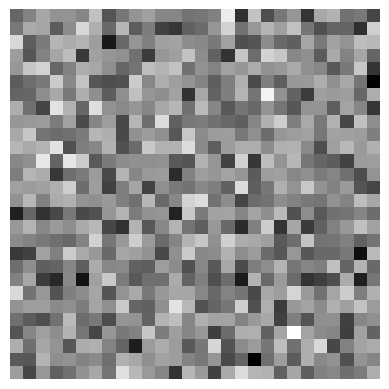

In [ ]:
show_image(output['x_rec'].view(1,28,28).detach())

In [ ]:
import math
import torch
import numpy as np
from torch import nn

## Losses

In [ ]:
class LossFunctions:
    eps = 1e-8

    def mean_squared_error(self, real, predictions):
      """Mean Squared Error between the true and predicted outputs
         loss = (1/n)*Σ(real - predicted)^2

      Args:
          real: (array) corresponding array containing the true labels
          predictions: (array) corresponding array containing the predicted labels

      Returns:
          output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      loss = (real - predictions).pow(2)
      return loss.sum(-1).mean()


    def reconstruction_loss(self, real, predicted, rec_type='mse' ):
      """Reconstruction loss between the true and predicted outputs
         mse = (1/n)*Σ(real - predicted)^2
         bce = (1/n) * -Σ(real*log(predicted) + (1 - real)*log(1 - predicted))

      Args:
          real: (array) corresponding array containing the true labels
          predictions: (array) corresponding array containing the predicted labels

      Returns:
          output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      if rec_type == 'mse':
        loss = (real - predicted).pow(2)
      elif rec_type == 'bce':
        loss = F.binary_cross_entropy(predicted, real, reduction='none')
      else:
        raise "invalid loss function... try bce or mse..."
      return loss.sum(-1).mean()


    def log_normal(self, x, mu, var):
      """Logarithm of normal distribution with mean=mu and variance=var
         log(x|μ, σ^2) = loss = -0.5 * Σ log(2π) + log(σ^2) + ((x - μ)/σ)^2

      Args:
         x: (array) corresponding array containing the input
         mu: (array) corresponding array containing the mean
         var: (array) corresponding array containing the variance

      Returns:
         output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      if self.eps > 0.0:
        var = var + self.eps
      return -0.5 * torch.sum(
        np.log(2.0 * np.pi) + torch.log(var) + torch.pow(x - mu, 2) / var, dim=-1)


    def gaussian_loss(self, z, z_mu, z_var, z_mu_prior, z_var_prior):
      """Variational loss when using labeled data without considering reconstruction loss
         loss = log q(z|x,y) - log p(z) - log p(y)

      Args:
         z: (array) array containing the gaussian latent variable
         z_mu: (array) array containing the mean of the inference model
         z_var: (array) array containing the variance of the inference model
         z_mu_prior: (array) array containing the prior mean of the generative model
         z_var_prior: (array) array containing the prior variance of the generative mode

      Returns:
         output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      loss = self.log_normal(z, z_mu, z_var) - self.log_normal(z, z_mu_prior, z_var_prior)
      return loss.mean()


    def entropy(self, logits, targets):
      """Entropy loss
          loss = (1/n) * -Σ targets*log(predicted)

      Args:
          logits: (array) corresponding array containing the logits of the categorical variable
          real: (array) corresponding array containing the true labels

      Returns:
          output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      log_q = F.log_softmax(logits, dim=-1)
      return -torch.mean(torch.sum(targets * log_q, dim=-1))

## Metrics

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score

class Metrics:

  # Code taken from the work
  # VaDE (Variational Deep Embedding:A Generative Approach to Clustering)
  def cluster_acc(self, Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
      w[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(w.max()-w)
    return sum([w[row[i],col[i]] for i in range(row.shape[0])]) * 1.0/Y_pred.size


  def nmi(self, Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    return normalized_mutual_info_score(Y_pred, Y, average_method='arithmetic')

In [ ]:
from torch import nn, optim

## Class GMVAE

In [1]:
class GMVAE:

  def __init__(self, args):
    self.num_epochs = args.epochs
    self.cuda = args.cuda
    self.verbose = args.verbose

    self.batch_size = args.batch_size
    self.batch_size_val = args.batch_size_val
    self.learning_rate = args.learning_rate
    self.decay_epoch = args.decay_epoch
    self.lr_decay = args.lr_decay
    self.w_cat = args.w_categ
    self.w_gauss = args.w_gauss
    self.w_rec = args.w_rec
    self.rec_type = args.rec_type

    self.num_classes = args.num_classes
    self.gaussian_size = args.gaussian_size
    self.input_size = args.input_size

    # gumbel
    self.init_temp = args.init_temp
    self.decay_temp = args.decay_temp
    self.hard_gumbel = args.hard_gumbel
    self.min_temp = args.min_temp
    self.decay_temp_rate = args.decay_temp_rate
    self.gumbel_temp = self.init_temp

    self.network = GMVAENet(self.input_size, self.gaussian_size, self.num_classes)
    self.losses = LossFunctions()
    self.metrics = Metrics()

    if self.cuda:
      self.network = self.network.cuda()


  def unlabeled_loss(self, data, out_net):
    """Method defining the loss functions derived from the variational lower bound
    Args:
        data: (array) corresponding array containing the input data
        out_net: (dict) contains the graph operations or nodes of the network output

    Returns:
        loss_dic: (dict) contains the values of each loss function and predictions
    """
    # obtain network variables
    z, data_recon = out_net['gaussian'], out_net['x_rec']
    logits, prob_cat = out_net['logits'], out_net['prob_cat']
    y_mu, y_var = out_net['y_mean'], out_net['y_var']
    mu, var = out_net['mean'], out_net['var']

    # reconstruction loss
    loss_rec = self.losses.reconstruction_loss(data, data_recon, self.rec_type)

    # gaussian loss
    loss_gauss = self.losses.gaussian_loss(z, mu, var, y_mu, y_var)

    # categorical loss
    loss_cat = -self.losses.entropy(logits, prob_cat) - np.log(0.1)

    # total loss
    loss_total = self.w_rec * loss_rec + self.w_gauss * loss_gauss + self.w_cat * loss_cat

    # obtain predictions
    _, predicted_labels = torch.max(logits, dim=1)

    loss_dic = {'total': loss_total,
                'predicted_labels': predicted_labels,
                'reconstruction': loss_rec,
                'gaussian': loss_gauss,
                'categorical': loss_cat}
    return loss_dic


  def train_epoch(self, optimizer, data_loader):
    """Train the model for one epoch

    Args:
        optimizer: (Optim) optimizer to use in backpropagation
        data_loader: (DataLoader) corresponding loader containing the training data

    Returns:
        average of all loss values, accuracy, nmi
    """
    self.network.train()
    total_loss = 0.
    recon_loss = 0.
    cat_loss = 0.
    gauss_loss = 0.

    accuracy = 0.
    nmi = 0.
    num_batches = 0.

    true_labels_list = []
    predicted_labels_list = []

    # iterate over the dataset
    for (data, labels) in data_loader:
      if self.cuda == 1:
        data = data.cuda()

      optimizer.zero_grad()

      # flatten data
      data = data.view(data.size(0), -1)

      # forward call
      out_net = self.network(data, self.gumbel_temp, self.hard_gumbel)
      unlab_loss_dic = self.unlabeled_loss(data, out_net)
      total = unlab_loss_dic['total']

      # accumulate values
      total_loss += total.item()
      recon_loss += unlab_loss_dic['reconstruction'].item()
      gauss_loss += unlab_loss_dic['gaussian'].item()
      cat_loss += unlab_loss_dic['categorical'].item()

      # perform backpropagation
      total.backward()
      optimizer.step()

      # save predicted and true labels
      predicted = unlab_loss_dic['predicted_labels']
      true_labels_list.append(labels)
      predicted_labels_list.append(predicted)

      num_batches += 1.

    # average per batch
    total_loss /= num_batches
    recon_loss /= num_batches
    gauss_loss /= num_batches
    cat_loss /= num_batches

    # concat all true and predicted labels
    true_labels = torch.cat(true_labels_list, dim=0).cpu().numpy()
    predicted_labels = torch.cat(predicted_labels_list, dim=0).cpu().numpy()

    # compute metrics
    accuracy = 100.0 * self.metrics.cluster_acc(predicted_labels, true_labels)
    nmi = 100.0 * self.metrics.nmi(predicted_labels, true_labels)

    return total_loss, recon_loss, gauss_loss, cat_loss, accuracy, nmi


  def test(self, data_loader, return_loss=False):
    """Test the model with new data

    Args:
        data_loader: (DataLoader) corresponding loader containing the test/validation data
        return_loss: (boolean) whether to return the average loss values

    Return:
        accuracy and nmi for the given test data

    """
    self.network.eval()
    total_loss = 0.
    recon_loss = 0.
    cat_loss = 0.
    gauss_loss = 0.

    accuracy = 0.
    nmi = 0.
    num_batches = 0.

    true_labels_list = []
    predicted_labels_list = []

    with torch.no_grad():
      for data, labels in data_loader:
        if self.cuda == 1:
          data = data.cuda()

        # flatten data
        data = data.view(data.size(0), -1)

        # forward call
        out_net = self.network(data, self.gumbel_temp, self.hard_gumbel)
        unlab_loss_dic = self.unlabeled_loss(data, out_net)

        # accumulate values
        total_loss += unlab_loss_dic['total'].item()
        recon_loss += unlab_loss_dic['reconstruction'].item()
        gauss_loss += unlab_loss_dic['gaussian'].item()
        cat_loss += unlab_loss_dic['categorical'].item()

        # save predicted and true labels
        predicted = unlab_loss_dic['predicted_labels']
        true_labels_list.append(labels)
        predicted_labels_list.append(predicted)

        num_batches += 1.

    # average per batch
    if return_loss:
      total_loss /= num_batches
      recon_loss /= num_batches
      gauss_loss /= num_batches
      cat_loss /= num_batches

    # concat all true and predicted labels
    true_labels = torch.cat(true_labels_list, dim=0).cpu().numpy()
    predicted_labels = torch.cat(predicted_labels_list, dim=0).cpu().numpy()

    # compute metrics
    accuracy = 100.0 * self.metrics.cluster_acc(predicted_labels, true_labels)
    nmi = 100.0 * self.metrics.nmi(predicted_labels, true_labels)

    if return_loss:
      return total_loss, recon_loss, gauss_loss, cat_loss, accuracy, nmi
    else:
      return accuracy, nmi


  def train(self, train_loader, val_loader):
    """Train the model

    Args:
        train_loader: (DataLoader) corresponding loader containing the training data
        val_loader: (DataLoader) corresponding loader containing the validation data

    Returns:
        output: (dict) contains the history of train/val loss
    """
    optimizer = optim.Adam(self.network.parameters(), lr=self.learning_rate)
    train_history_acc, val_history_acc = [], []
    train_history_nmi, val_history_nmi = [], []

    for epoch in range(1, self.num_epochs + 1):
      train_loss, train_rec, train_gauss, train_cat, train_acc, train_nmi = self.train_epoch(optimizer, train_loader)
      val_loss, val_rec, val_gauss, val_cat, val_acc, val_nmi = self.test(val_loader, True)

      # if verbose then print specific information about training
      if self.verbose == 1:
        print("(Epoch %d / %d)" % (epoch, self.num_epochs) )
        print("Train - REC: %.5lf;  Gauss: %.5lf;  Cat: %.5lf;" % \
              (train_rec, train_gauss, train_cat))
        print("Valid - REC: %.5lf;  Gauss: %.5lf;  Cat: %.5lf;" % \
              (val_rec, val_gauss, val_cat))
        print("Accuracy=Train: %.5lf; Val: %.5lf   NMI=Train: %.5lf; Val: %.5lf   Total Loss=Train: %.5lf; Val: %.5lf" % \
              (train_acc, val_acc, train_nmi, val_nmi, train_loss, val_loss))
      else:
        print('(Epoch %d / %d) Train_Loss: %.3lf; Val_Loss: %.3lf   Train_ACC: %.3lf; Val_ACC: %.3lf   Train_NMI: %.3lf; Val_NMI: %.3lf' % \
              (epoch, self.num_epochs, train_loss, val_loss, train_acc, val_acc, train_nmi, val_nmi))

      # decay gumbel temperature
      if self.decay_temp == 1:
        self.gumbel_temp = np.maximum(self.init_temp * np.exp(-self.decay_temp_rate * epoch), self.min_temp)
        if self.verbose == 1:
          print("Gumbel Temperature: %.3lf" % self.gumbel_temp)

      train_history_acc.append(train_acc)
      val_history_acc.append(val_acc)
      train_history_nmi.append(train_nmi)
      val_history_nmi.append(val_nmi)
    return {'train_history_nmi' : train_history_nmi, 'val_history_nmi': val_history_nmi,
            'train_history_acc': train_history_acc, 'val_history_acc': val_history_acc}


  def latent_features(self, data_loader, return_labels=False):
    """Obtain latent features learnt by the model

    Args:
        data_loader: (DataLoader) loader containing the data
        return_labels: (boolean) whether to return true labels or not

    Returns:
       features: (array) array containing the features from the data
    """
    self.network.eval()
    N = len(data_loader.dataset)
    features = np.zeros((N, self.gaussian_size))
    if return_labels:
      true_labels = np.zeros(N, dtype=np.int64)
    start_ind = 0
    with torch.no_grad():
      for (data, labels) in data_loader:
        if self.cuda == 1:
          data = data.cuda()
        # flatten data
        data = data.view(data.size(0), -1)
        out = self.network.inference(data, self.gumbel_temp, self.hard_gumbel)
        latent_feat = out['mean']
        end_ind = min(start_ind + data.size(0), N+1)

        # return true labels
        if return_labels:
          true_labels[start_ind:end_ind] = labels.cpu().numpy()
        features[start_ind:end_ind] = latent_feat.cpu().detach().numpy()
        start_ind += data.size(0)
    if return_labels:
      return features, true_labels
    return features


  def reconstruct_data(self, data_loader, sample_size=-1):
    """Reconstruct Data

    Args:
        data_loader: (DataLoader) loader containing the data
        sample_size: (int) size of random data to consider from data_loader

    Returns:
        reconstructed: (array) array containing the reconstructed data
    """
    self.network.eval()

    # sample random data from loader
    indices = np.random.randint(0, len(data_loader.dataset), size=sample_size)
    test_random_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=sample_size, sampler=SubsetRandomSampler(indices))

    # obtain values
    it = iter(test_random_loader)
    test_batch_data, _ = next(it) #MODIFIED
    original = test_batch_data.data.numpy()
    if self.cuda:
      test_batch_data = test_batch_data.cuda()

    # obtain reconstructed data
    out = self.network(test_batch_data, self.gumbel_temp, self.hard_gumbel)
    reconstructed = out['x_rec']
    return original, reconstructed.data.cpu().numpy()


  def plot_latent_space(self, data_loader, save=False):
    """Plot the latent space learnt by the model

    Args:
        data: (array) corresponding array containing the data
        labels: (array) corresponding array containing the labels
        save: (bool) whether to save the latent space plot

    Returns:
        fig: (figure) plot of the latent space
    """
    # obtain the latent features
    features = self.latent_features(data_loader)

    # plot only the first 2 dimensions
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=labels, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.colorbar()
    if(save):
        fig.savefig('latent_space.png')
    return fig


  def random_generation(self, num_elements=1):
    """Random generation for each category

    Args:
        num_elements: (int) number of elements to generate

    Returns:
        generated data according to num_elements
    """
    # categories for each element
    arr = np.array([])
    for i in range(self.num_classes):
      arr = np.hstack([arr,np.ones(num_elements) * i] )
    indices = arr.astype(int).tolist()

    categorical = F.one_hot(torch.tensor(indices), self.num_classes).float()

    if self.cuda:
      categorical = categorical.cuda()

    # infer the gaussian distribution according to the category
    mean, var = self.network.generative.pzy(categorical)

    # gaussian random sample by using the mean and variance
    noise = torch.randn_like(var)
    std = torch.sqrt(var)
    gaussian = mean + noise * std

    # generate new samples with the given gaussian
    generated = self.network.generative.pxz(gaussian)

    return generated.cpu().detach().numpy()

In [3]:
gmvae = GMVAE(args)

NameError: name 'args' is not defined

In [ ]:
## Training Phase
history_loss = gmvae.train(train_loader, val_loader)

(Epoch 1 / 300) Train_Loss: 156.620; Val_Loss: 125.184   Train_ACC: 34.580; Val_ACC: 44.910   Train_NMI: 23.456; Val_NMI: 34.677
(Epoch 2 / 300) Train_Loss: 118.523; Val_Loss: 112.597   Train_ACC: 45.902; Val_ACC: 48.270   Train_NMI: 35.800; Val_NMI: 37.766
(Epoch 3 / 300) Train_Loss: 110.748; Val_Loss: 107.703   Train_ACC: 49.372; Val_ACC: 53.170   Train_NMI: 38.217; Val_NMI: 42.312
(Epoch 4 / 300) Train_Loss: 107.203; Val_Loss: 105.399   Train_ACC: 53.392; Val_ACC: 56.120   Train_NMI: 41.250; Val_NMI: 43.859
(Epoch 5 / 300) Train_Loss: 105.089; Val_Loss: 104.384   Train_ACC: 57.337; Val_ACC: 59.680   Train_NMI: 44.221; Val_NMI: 47.576
(Epoch 6 / 300) Train_Loss: 103.658; Val_Loss: 102.872   Train_ACC: 60.757; Val_ACC: 62.000   Train_NMI: 47.509; Val_NMI: 50.377
(Epoch 7 / 300) Train_Loss: 102.597; Val_Loss: 101.931   Train_ACC: 62.858; Val_ACC: 64.670   Train_NMI: 49.841; Val_NMI: 53.261
(Epoch 8 / 300) Train_Loss: 101.784; Val_Loss: 101.836   Train_ACC: 64.607; Val_ACC: 66.090   Tra

In [ ]:
accuracy, nmi = gmvae.test(test_loader)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi) )

Testing phase...
Accuracy: 84.44000,  NMI: 76.56263


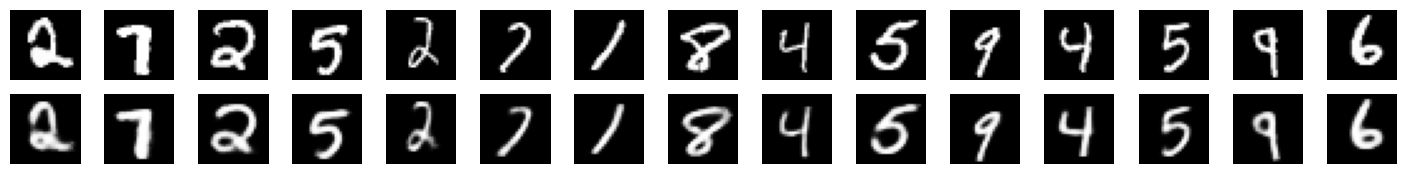

In [ ]:
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')

    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

original, reconstructed = gmvae.reconstruct_data(test_loader, 15)
display_reconstructed(original, reconstructed, 15)

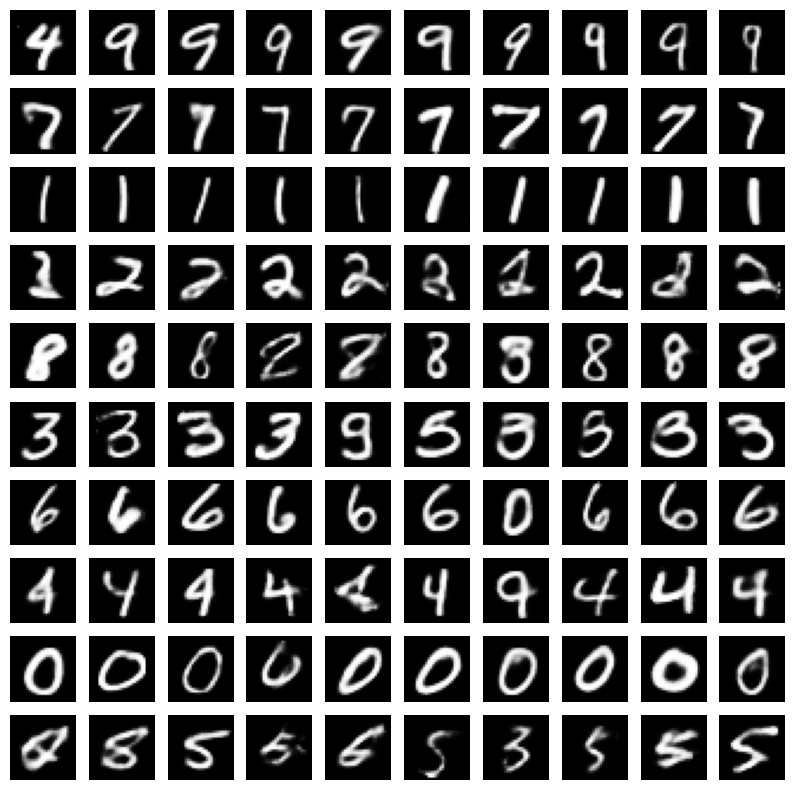

In [ ]:
def display_random_generation(generated, num_classes, n=10):
  plt.figure(figsize=[10,10])
  for c in range(num_classes):
    for i in range(n):
      plt.subplot(num_classes, n, (c * n) + i + 1)
      plt.imshow(generated[(c * n) + i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

elem_per_category = 10
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

## Visualization of the feature latent space

In [ ]:
# get feature representations
test_features, test_labels = gmvae.latent_features(test_loader, True)

In [ ]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm
tsne_features = TSNE(n_components=2).fit_transform(test_features[:1000,])

<ipython-input-48-c89cc863712f>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)


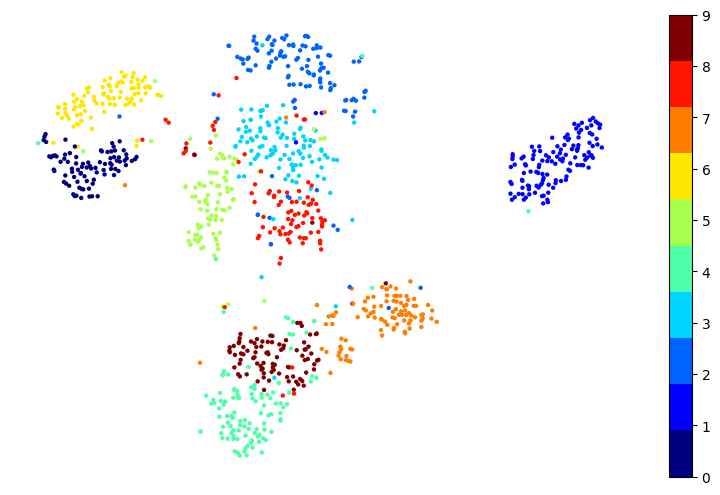

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('off')
plt.colorbar()